# 1. 项目介绍

对于信用卡发行公司而言，用户欺诈交易行为可能会造成持卡人和信用卡公司利益的严重损失，因此利用交易信息对欺诈行为进行检测，有助于发卡机构实现反欺诈，保护持卡人的财产安全。

本项目采用比利时布鲁塞尔自由大学(ULB)Worldline and the Machine Learning Group提供的开源数据集Credit Card Fraud Detection，数据集包含了2013年9月欧洲地区信用卡持卡人在2天内的交易记录，共计284,807条记录，其中存在492条欺诈交易数据，数据特征如下：

- Time：交易发生时间距数据集首条交易发生时间的时间间隔，单位为秒；
- V1-V28：数值变量经过PCA变换后得到的主成分，由于保密原因无法获得数据背景信息；
- Amount：交易金额；
- Class：是否欺诈交易行为，1-是，0-否。

本项目旨在利用该数据集，探究不平衡数据集处理方式对于分类器分类性能的影响。

# 2. 数据探索
## 2.1 数据导入

In [1]:
# 导入相关库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spstats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids, TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
import warnings
warnings.filterwarnings(filter='ignore')

In [2]:
# 数据导入
data_origin = pd.read_csv('./creditcard.csv')
data_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- 数据集包含284807条数据，没有缺失值，推测已完成了数据清理。

## 2.2 长尾分布变换

D:\SoftWares\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Amount', ylabel='Density'>

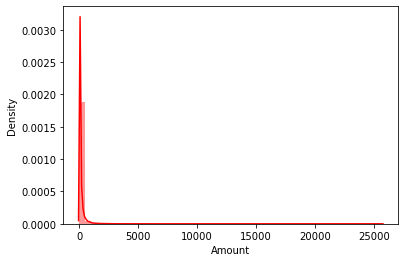

In [3]:
sns.distplot(data_origin["Amount"], color='r')

- Amount数据分布存在明显的数据倾斜，不符合正态分布特点，对于后续模型训练存在不利影响。我们可以使用特征工程技巧，利用统计或数学变换来减轻数据分布倾斜的影响，帮助稳定方差，保持数据分布接近于正态分布。

- Box-Cox变换是Box和Cox在1964年提出的一种广义幂变换方法，是统计建模中常用的一种数据变换，用于连续的响应变量不满足正态分布的情况。Box-Cox变换之后，可以一定程度上减小不可观测的误差和预测变量的相关性。

- Box-Cox变换方法显著优点是通过求变换参数来确定变换形式，而这个过程完全基于数据本身而无须任何先验信息，这无疑比凭经验或通过尝试而选用对数、平方根等变换方式要客观和精确。

D:\SoftWares\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Amount', ylabel='Density'>

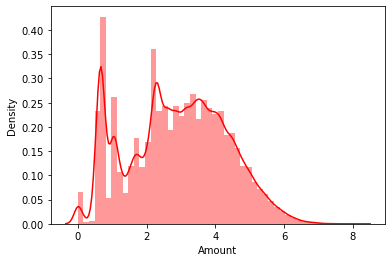

In [4]:
# 保存副本

data = data_origin.copy()
# BoxCox变换
Amount = np.array(data['Amount'].apply(lambda x:x+1))
l, opt_lambda = spstats.boxcox(Amount)
data['Amount'] = spstats.boxcox(Amount, lmbda=opt_lambda)
sns.distplot(data['Amount'],color='r')

## 2.3 数据分桶
- Time列采用秒作为单位，过于精细，为了减少次要观察误差的影响，以小时为单位对Time数据进行分桶。

In [5]:
# 数据分桶
data['Time'] = pd.cut(data['Time'], bins=3600*np.arange(49),
                      include_lowest=True, labels=np.arange(1, 49))
data['Time']=data['Time'].astype('int')

## 2.4 数据集偏斜



In [6]:
# 目标类别分布
data_origin['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

可见，数据集偏斜现象非常严重，正类只占全部数据的0.17%，如果不对偏斜问题进行处理，即便使用全0分类器，模型预测准确率都能达到99.83%。

业界采用的解决分类数据偏斜的方法主要有

- 欠采样： 对大类的数据样本进行采样来减少该类数据样本的个数，通常删除部分大类样本数据
- 过采样： 对小类的数据样本进行采样来增加小类的数据样本个数，通常增加部分小类样本数据的副本
- 数据加权：将大类样本依据类别分布比例（权值）随机划分成一系列不相交子集，分别将这些不相交子集跟小类样本结合，组成一系列平衡的分类子问题，单独训练成子分类器，最后将这些子分类器的输出进一步学习成组合分类器；
- 集成方法：对大类和小类类分别进行多次重采样，采用多数投票的方法进行集成学习；
- 代价敏感方法：赋予各个类别不同的错分代价，对错分小类样本做更大的惩罚迫使最终分类器对正类样本有更高的识别率；
- 一分类：即将研究问题视作一分类（异常检测）问题。

常规做法为对大类样本欠采样，对小类样本过采样，但是欠采样过程会导致大量的信息损失，过采样由于引入大量的副本数据，容易出现过拟合现象。为解决上述问题，业界提出了多种改进方法，例如SMOTE，ADASYN等。

本项目采用常见的过采样和欠采样方法处理原始数据集不平衡问题，代码基于imblearn库实现，分类器选择Logstic Regression。

## 2.5 数据相关性

<AxesSubplot:>

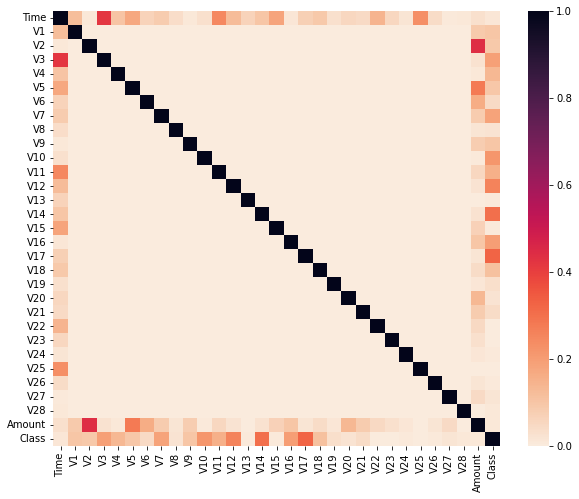

In [7]:
# 数据相关性
plt.figure(figsize=(10,8))
sns.heatmap(data.corr().abs(),cmap=sns.cm.rocket_r)

与分类结果相关性较高的特征有V3,V7,V10,V12,V14,V17等特征，可以针对这些变量进行特征工程，本项目重点关注偏斜数据集的处理，对此不予细究。

## 2.6 训练数据准备

- 进行模型训练需要分离目标变量和特征变量，并划分测试集进行最终评估。

In [8]:
# 分离目标变量
X = data.drop('Class', axis=1)
y = data['Class']
# 训练集测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# 3. 性能指标

- 对于偏斜数据集，由于各类别数据量差异悬殊，准确率不能作为模型训练效果的判别标准，需要引入新的评价指标和评价方式。

## 3.1 混淆矩阵

- 混淆矩阵将分类器的分类结果采用矩阵形式直观展示，对于一个二元分类器，混淆矩阵为2×2矩阵。

- 实际应用中，自然是希望模型越准越好，即TP与TN越多，FP与FN越少。

## 3.2 二级指标

- 查准率(precision)：预测为正类的样本中，实际为正类样本的比例。
- 召回率(recall)：所有正类样本中，被预测为正类样本的比例。


- 查准率和召回率是互相矛盾的一对指标，阈值越大，查准率越高，但查全率会降低，反之，减小阈值可以增加查全率，但查准率相应会降低。

- 为了综合判断查准率-查全率之间的权衡关系，引入F1分数(F1 score)进行评价。

- F1-分数综合了Precision与Recall的影响，取值范围从0到1，1代表模型的输出最好，0代表模型的输出结果最差。

## 3.3 PR曲线
- PR曲线可以直观反映查准率和召回率的权衡关系，横纵轴分别表示召回率和查准率，曲线上每一点对应了一个分类阈值下的P和R，通常，阈值增加，查准率会升高，但召回率会下降。

- 显然，我们希望分类器预测效果又全又准，因此期望PR曲线越靠近右上越好。实际应用时该曲线可能存在波动，并不一定是图中的光滑曲线。Scikit-learn提供average_precision_score函数可以计算PR曲线与坐标轴围成的面积(AP)，用以评价PR曲线的优劣。


## 3.4 ROC曲线

- ROC曲线是一种常用于二元分类器的评价方式，横纵轴分别对应TPR(真正类率，即recall)和FPR(假正类率，即被错误分类为正类的非正类比例），这里再次面临一个折中权衡：召回率（TPR）越高，分类器产生的假正类（FPR）就越多。

- 常见的利用ROC曲线评价分类器的方法是测量曲线下面积（AUC）。完美分类器的ROC曲线的AUC等于1，而纯随机分类器的AUC等于0.5，ROC曲线越靠近左上角，分类器效果越好。

- 本项目采用PR曲线和ROC曲线对分类器进行一个初步的评估，使用Logistic回归模型，探究不平衡数据集处理方式对分类器效果的影响。作为对比，先计算不进行处理情况下分类器的效果。

In [9]:
X_train.shape

(227845, 30)

In [10]:
def model_train(X_train, y_train, X_test, y_test):
    params = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grid_log_clf = GridSearchCV(LogisticRegression(random_state=42),
                                params, cv=3, scoring='f1')
    grid_log_clf.fit(X_train, y_train)
    log_clf = grid_log_clf.best_estimator_
    y_test_score = log_clf.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    p, r, _ = precision_recall_curve(y_test, y_test_score)
    roc_auc = auc(fpr, tpr)
    ap = average_precision_score(y_test, y_test_score)
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.plot(p, r, 'r', label='AP  = %0.3f' % ap)
    plt.legend()
    plt.show()
    return p, r

C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

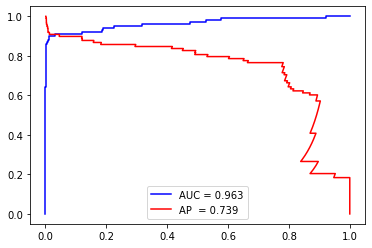

In [11]:
p0, r0 = model_train(X_train, y_train, X_test, y_test)


对于严重不平衡数据集，ROC曲线的评估结果过于乐观，PR曲线相对更具参考性。可见，不进行任何处理直接采用Logistic回归模型训练的话，PR曲线离右上相对较远，召回率0.8时，准确率只能达到0.7左右，AP值为0.742，具备较大的提升空间。

# 4. 欠采样
随机欠采样指从大类样本中随机抽取样本与小类样本组合成平衡数据集，抽样过程完全随机。

C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

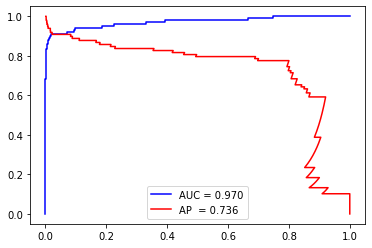

In [12]:
'''随机欠采样'''
rus = RandomUnderSampler(random_state=42)
X_res_rus, y_res_rus = rus.fit_resample(X_train, y_train)
p_rus, r_rus = model_train(X_res_rus, y_res_rus, X_test, y_test)

随机欠采样后PR曲线波动更为剧烈，AP值反而下降，这是由于欠采样过程中大类样本存在大量的信息损失，影响分类器的分类性能。

## 4.2 Nearmiss方法


Nearmiss方法在随机欠采样的基础上，添加了某些规则来选择样本，通过设定version参数来实现三种不同采样规则：

- NearMiss-1: 选择离N个最近的小类样本的平均距离最小的大类样本;
- NearMiss-2: 选择离N个最远的小类样本的平均距离最小的大类样本
- NearMiss-3: 首先，对于每一个小类样本, 保留它们的M个近邻样本; 然后，选择与N个最近小类样本的平均距离最大的大类样本

D:\SoftWares\Anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. o

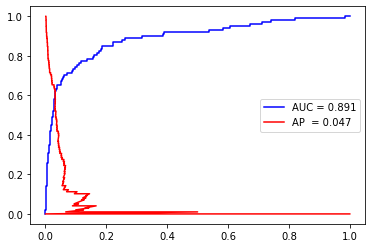

C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

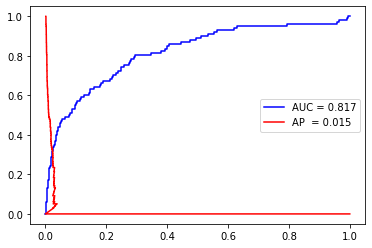

C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

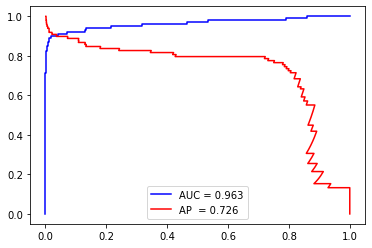

In [13]:
'''Nearmiss'''
nm1 = NearMiss(version=1)
nm2 = NearMiss(version=2)
nm3 = NearMiss(version=3)
X_res_nm1, y_res_nm1 = nm1.fit_resample(X_train, y_train)
X_res_nm2, y_res_nm2 = nm2.fit_resample(X_train, y_train)
X_res_nm3, y_res_nm3 = nm3.fit_resample(X_train, y_train)
p_nm1, r_nm1 = model_train(X_res_nm1, y_res_nm1, X_test, y_test)
p_nm2, r_nm2 = model_train(X_res_nm2, y_res_nm2, X_test, y_test)
p_nm3, r_nm3 = model_train(X_res_nm3, y_res_nm3, X_test, y_test)

Nearmiss-1和Nearmiss-2方法处理后，训练模型的ROC曲线和PR曲线显著劣化，AP值大幅下降，分类器性能已不如随机分类器。这两种方法都会受到明显的噪声影响，由于小类样本中离群点的存在，导致采样结果不具代表性。相对而言，Nearmiss-3方法减弱了噪声影响，处理结果最好，但是分类效果并没有显著提升。

## 4.3 ClusterCentorids方法

ClusterCentorids方法采用Kmeans算法，通过生成原始数据集的聚类中心作为采样点，以减少大类样本中的样本数量。该方法为典型的原型生成算法，即不直接使用原始数据集，而是生成新的数据点，利用聚类减小了欠采样过程中的信息损失，但大大增加了处理时间，并且效果优劣取决于原始数据集是否表现出分簇趋势。



C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

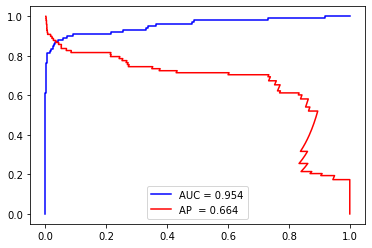

In [14]:
'''ClusterCentorids'''
cc = ClusterCentroids(random_state=42)
X_res_cc, y_res_cc = cc.fit_resample(X_train, y_train)
p_cc, r_cc = model_train(X_res_cc, y_res_cc, X_test, y_test)

ClusterCentorids方法处理后PR曲线最优点没有没有提升，AP值下降，初步判断是正常交易数据之间差异较大，因此原始数据集中的大类样本并不能聚类成簇，导致聚类形成的数据集并不能代表原始数据，分类效果较差。

## 4.4 数据清洗方法

数据清洗方法通过某些规则来清洗大类样本中重叠的数据，从而达到欠采样的目的。通常采用Tomek link和Edited Nearest Neighbours(ENN)两种算法。

- Tomek link：如果两个不同类别的样本互为最近邻，那么这两个样本构成一个Tomek link，两个样本中必有一个为噪声，或者两个样本都处于分类边界上。通过删除所有Tomek link中的大类样本，可以清洗类间重叠样本，保证互为最近邻的样本属于同类，便于更好地分类。


- Edited Nearest Neighbours(ENN)：如果某个大类样本中的近邻样本中有一半以上属于小类，那么直接删除该大类样本。

数据清洗方法最大的缺点是无法控制欠采样的数量。两种算法都在一定程度上采用了K近邻方法，而事实上大部分大类样本周围也都是大类，因而能剔除的大类样本较少，欠采样效果有限。

C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

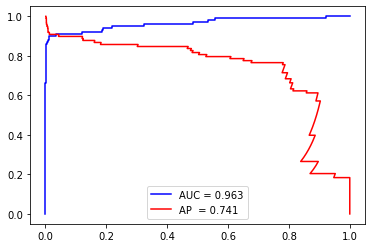

C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

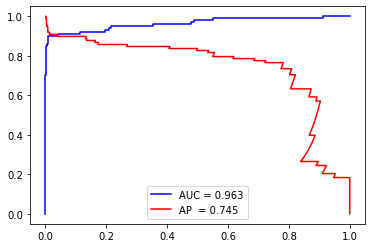

In [15]:
'''Tomek link'''
tl = TomekLinks()
X_res_tl, y_res_tl = tl.fit_resample(X_train, y_train)
p_tl, r_tl = model_train(X_res_tl, y_res_tl, X_test, y_test)

'''ENN'''
enn = EditedNearestNeighbours()
X_res_enn, y_res_enn = enn.fit_resample(X_train, y_train)
p_enn, r_enn = model_train(X_res_enn, y_res_enn, X_test, y_test)

数据清洗方法处理后的PR曲线最优点位置与未处理情况差异不大，查看欠采样后大类样本数量变化。

In [16]:
print('Original: ', y_train[y_train == 0].count())
print('After Tomek Link: ', y_res_tl[y_res_tl == 0].count())
print('After ENN: ', y_res_enn[y_res_enn == 0].count())

Original:  227451
After Tomek Link:  227431
After ENN:  227312


两种方法清洗的大类样本数量非常有限，相对而言，ENN倾向于清洗更多的样本。由于数据处理前后变化较小，因此分类器性能提升非常有限。



# 5. 过采样
## 5.1 随机过采样


随机过采样方法随机选择小类样本中的数据点，通过复制数据副本方式增加小类样本数据量从而形成平衡数据集。




In [17]:
'''随机过采样'''
ros = RandomOverSampler(random_state=42)
X_res_ros, y_res_ros = ros.fit_resample(X_train, y_train)
p_ros, r_ros = model_train(X_res_ros, y_res_ros, X_test, y_test)

C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\dong3\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

KeyboardInterrupt: 

随机过采样方法处理后，最优点可以保证查准率和召回率同时达到80%以上，AP值也有少量提高，分类性能较未处理情况有一定提升。


## 5.2 SMOTE方法

SMOTE方法是一种经典的过采样改进方法，基于“插值”为小类合成新的样本，从而改变数据集中不平衡的类别比例。该方法利用了K近邻算法思想，具体采样步骤为：

- 对于每一个小类数据点，找到它的k个最近相邻小类数据点；
- 从k个数据点中随机挑选n个，在原始数据点和这n个点之间各选一点，构造新的小类样本；
- 将新样本与原始数据结合，形成新数据集。


SMOTE实现简单，但其弊端也很明显，可能会在小类离群点周围插值导致生成大量的噪声样本，影响分类器效果。

In [ ]:
'''SMOTE'''
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X_train, y_train)
p_smote, r_smote = model_train(X_res_smote, y_res_smote, X_test, y_test)

SMOTE方法较随机过采样方法在分类性能上有了一定的提高。

## 5.3 ADASYN方法

5.3 ADASYN方法

ADASYN方法在SMOTE方法基础上，引入了自适应算法，对不同的小类样本赋予不同的权重，进而生成不同数量的新样本，具体计算步骤为：

- 计算每个小类数据点K近邻中大类样本的比例  ；
- 将 标准化后作为各小类数据点的权重，依据该权重计算每个小类样本需要生成的新样本数量 ;
- 对每个小类数据点使用SMOTE方法，生成个新样本点，完成过采样。
- ADASYN方法倾向于对周围大类样本较多的小类样本进行更多的SMOTE过采样。

In [ ]:
'''ADASYN'''
adasyn = ADASYN(random_state=42)
X_res_ada, y_res_ada = adasyn.fit_resample(X_train, y_train)
p_ada, r_ada = model_train(X_res_ada, y_res_ada, X_test, y_test)

ADASYN方法与SMOTE方法结果差异不大，推测小类样本中离群点较少，ADASYN优化效果有限。

# 6. 过采样与欠采样结合
- SMOTE算法的缺点是生成的小类样本容易与周围的大类样本产生重叠难以分类，而数据清洗技术恰好可以处理掉重叠样本，二者可以结合，先采用SMOTE算法进行过采样，然后进行数据清洗删除重叠样本，提高分类性能。

- 过采样与欠采样结合方法通常使用SMOTE+ENN和SMOTE+Tomek link两种方法进行。

- SMOTEENN和SMOTETomek算法结合了过采样和欠采样的优势，取得了最好的分类性能，但处理时间大大增加，实际运用时需要衡量时间成本和计算准确度的取舍。



# 7. 总结
- 对于不平衡数据集，直接针对原始数据集进行模型训练效果较差，常规做法是采用过采样和欠采样分别针对小类样本和大类样本进行采样处理。
- 对不平衡数据集分类结果进行评价时，ROC曲线的参考价值较低，因为类别分布的悬殊会导致ROC曲线评价结果过分乐观，针对严重不平衡数据集，PR曲线更具有参考价值。
- 对于信用卡欺诈交易检测这类类别不平衡现象非常严重的数据集，欠采样的信息损失问题造成的影响较大，欠采样方法效果普遍不佳，而过采样的过拟合问题通过改进采样方法和增加样本量可以较好地解决，此外，采用过采样和欠采样结合的方法处理后的分类效果最好，但也会大大增加时间成本，需要进行权衡。
- 对于高度偏斜的数据集，通过改进采样方式得到的性能提升非常有限，实际训练时仍需改进Base model和进行深入的特征工程以进一步提高分类性能。